<a href="https://colab.research.google.com/github/Jdka1/Course-Assignment/blob/main/Algos_Final_Exploration_Aryan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For my final exploration, I looked into course assignment algorithms (not sure the formal term for this). I've heard a lot of complaints about the speed, accuracy, and fairness of Nueva's course selection system, so I attempted to model this environment and create a few algorithms for allocating students their desired classes to solve this problem. Each test case has a list of students with certain preferences, which are skewed towards certain popular classes that don't have enough space for all the students who want them, and they submit a request form of their desired classes list, as well as the number of total classes they want. The algorithms then have their own ways of giving priority to certain students or metrics and assign courses one-by-one this way.

In [1]:
import random
import heapq
from collections import defaultdict, deque
import time
import numpy as np
from typing import List, Dict, Tuple, Set
import matplotlib.pyplot as plt

In [2]:
class Student:
    def __init__(self, student_id: int, preferences: List[int], desired_classes: int = None):
        self.id = student_id
        self.preferences = preferences  # Ordinal list of classes by preference
        self.assigned_classes = set()  # Set of classes they were assigned
        self.desired_classes = desired_classes or min(3, len(preferences))  # Num classes they put down

    def get_satisfaction(self) -> float:
        """Return satisfaction score based on assigned classes"""
        if not self.assigned_classes:
            return 0.0

        total_satisfaction = 0
        for class_id in self.assigned_classes:
            if class_id in self.preferences:
                # Higher satisfaction for higher preference index (because that class was higher in their ranking)
                rank = self.preferences.index(class_id) + 1
                satisfaction = max(0, len(self.preferences) - rank + 1)
                total_satisfaction += satisfaction

        # They are more satisfied if they get the exact # of classes they asked for
        completeness_bonus = len(self.assigned_classes) / self.desired_classes
        return total_satisfaction * completeness_bonus

    def can_take_more_classes(self) -> bool:
        """Check if student can take more classes"""
        return len(self.assigned_classes) < self.desired_classes

    def get_next_preference(self, exclude_assigned: bool = True) -> int:
        """Get next preferred class that student isn't already taking"""
        for class_id in self.preferences:
            if not exclude_assigned or class_id not in self.assigned_classes:
                return class_id
        return None

In [3]:
class ClassRoom:
    def __init__(self, class_id: int, capacity: int):
        self.id = class_id
        self.capacity = capacity
        self.enrolled_students = set()

    def can_enroll(self) -> bool:
        return len(self.enrolled_students) < self.capacity

    def enroll_student(self, student: Student) -> bool:
        if self.can_enroll() and student.can_take_more_classes():
            self.enrolled_students.add(student.id)
            student.assigned_classes.add(self.id)
            return True
        return False

    def remove_student(self, student: Student):
        """Remove student from class"""
        if student.id in self.enrolled_students:
            self.enrolled_students.remove(student.id)
            student.assigned_classes.discard(self.id)

# Course Assignment Algorithms

In [4]:
class AssignmentSystem:
    def __init__(self, students: List[Student], classes: List[ClassRoom]):
        self.students = students
        self.classes = classes
        self.class_dict = {c.id: c for c in classes}

    def reset_assignments(self):
        """Reset all assignments for fresh algorithm run"""
        for student in self.students:
            student.assigned_classes = set()
        for classroom in self.classes:
            classroom.enrolled_students = set()

    def calculate_metrics(self) -> Dict:
        """Calculate various performance metrics"""
        total_satisfaction = sum(s.get_satisfaction() for s in self.students)
        total_assignments = sum(len(s.assigned_classes) for s in self.students)
        total_desired = sum(s.desired_classes for s in self.students)

        # How many students got their desired number of classes (fully satisfied courseload)?
        fully_satisfied = sum(1 for s in self.students
                            if len(s.assigned_classes) >= s.desired_classes)

        # Fairness of final outcome (standard deviation of satisfaction scores of students)
        satisfactions = [s.get_satisfaction() for s in self.students]
        fairness_score = np.std(satisfactions) if satisfactions else 0

        # Utilization of class space
        total_capacity = sum(c.capacity for c in self.classes)
        utilization = total_assignments / total_capacity if total_capacity > 0 else 0

        # How many students got top choices
        top_choice_count = 0
        for student in self.students:
            if student.preferences and student.preferences[0] in student.assigned_classes:
                top_choice_count += 1

        return {
            'total_satisfaction': total_satisfaction,
            'avg_satisfaction': total_satisfaction / len(self.students) if self.students else 0,
            'assignment_rate': total_assignments / total_desired if total_desired > 0 else 0,
            'full_satisfaction_rate': fully_satisfied / len(self.students) if self.students else 0,
            'fairness_score': fairness_score,  # Lower => more fair
            'utilization': utilization,
            'top_choice_rate': top_choice_count / len(self.students) if self.students else 0
        }








# STUDENT-CLASS MATCHING ALGORITHMS
# --------------------------------------------------------------------------------------------------------------


    # Algorithm 1: Round-Robin Draft
    def round_robin_assignment(self) -> Dict:
        """
        Students take turns picking their most preferred available class.
        Continue until no more assignments possible.
        """
        self.reset_assignments()

        round_num = 0
        assignments_made = True

        while assignments_made:
            assignments_made = False
            students_shuffled = self.students.copy()
            random.shuffle(students_shuffled)

            for student in students_shuffled:
                if not student.can_take_more_classes():
                    continue

                for preferred_class_id in student.preferences:
                    if (preferred_class_id in self.class_dict and
                        preferred_class_id not in student.assigned_classes):
                        classroom = self.class_dict[preferred_class_id]
                        if classroom.enroll_student(student):
                            assignments_made = True
                            break

            round_num += 1
            if round_num > 10:
                break

        return self.calculate_metrics()




    # Algorithm 2: Unfair/Greedy
    def greedy_multiclass_assignment(self) -> Dict:
        """
        Create all possible (student, class) pairs, sort by value, assign greedily.
        Students can get multiple classes. Maximized TOTAL utility growth at each step but doesn't care about each individual's fair outcome.
        """
        self.reset_assignments()

        assignments = []
        for student in self.students:
            for i, class_id in enumerate(student.preferences):
                if class_id in self.class_dict:
                    base_value = len(student.preferences) - i
                    need_multiplier = student.desired_classes / max(1, len(student.preferences))
                    value = base_value * need_multiplier
                    assignments.append((value, student, class_id))

        assignments.sort(key=lambda x: x[0], reverse=True)

        for value, student, class_id in assignments:
            if (student.can_take_more_classes() and
                class_id not in student.assigned_classes):
                classroom = self.class_dict[class_id]
                classroom.enroll_student(student)

        return self.calculate_metrics()




    # Algorithm 3: Boston / Preference‑Tiered Assignment
    def boston_assignment(self) -> Dict:
        """
        Rank‑by‑rank allocation:
        - Round 0: everyone applies to their 1st‑choice class
        - Each class accepts up to its remaining capacity, breaking ties
            by who still needs the most classes (then random).
        - Rejected or still‑needy students advance to their 2nd choice,
            and so on, until no one can be assigned further
        """
        self.reset_assignments()

        max_rank = max((len(s.preferences) for s in self.students), default=0)

        for rank in range(max_rank):
            class_applicants: Dict[int, list[Student]] = defaultdict(list)

            for student in self.students:
                if student.can_take_more_classes() and rank < len(student.preferences):
                    cid = student.preferences[rank]
                    if (cid in self.class_dict     # class exists
                            and cid not in student.assigned_classes):
                        class_applicants[cid].append(student)

            for cid, applicants in class_applicants.items():
                classroom = self.class_dict[cid]
                seats_left = classroom.capacity - len(classroom.enrolled_students)
                if seats_left <= 0:
                    continue

                applicants.sort(
                    key=lambda s: (
                        s.desired_classes - len(s.assigned_classes),
                        random.random()
                    ),
                    reverse=True
                )

                for student in applicants[:seats_left]:
                    classroom.enroll_student(student)

        return self.calculate_metrics()







    # Algorithm 4: Gale-Shapley
    def multiround_deferred_acceptance(self) -> Dict:
        """
        Students propose to classes, and each class lets in as many student it can, starting from the students who prioritized the class the highest.
        Repeat until terminated.
        """
        self.reset_assignments()

        max_rounds = 15
        for round_num in range(max_rounds):
            class_proposals = defaultdict(list)

            proposals_made = False

            for student in self.students:
                if not student.can_take_more_classes():
                    continue

                for rank, class_id in enumerate(student.preferences):
                    if (class_id in self.class_dict and
                        class_id not in student.assigned_classes):
                        class_proposals[class_id].append((student, rank))
                        proposals_made = True
                        break

            if not proposals_made:
                break

            for class_id, proposals in class_proposals.items():
                classroom = self.class_dict[class_id]

                proposals.sort(key=lambda x: x[1])

                for student, rank in proposals:
                    if classroom.can_enroll() and student.can_take_more_classes():
                        classroom.enroll_student(student)

        return self.calculate_metrics()

    # Algorithm 5: Tiered Satisfaction-Weighted Assignment
    def satisfaction_weighted_assignment(self) -> Dict:
        """
        Multi-pass algorithm that first processes each preference rank tier globally
        (like Boston), then assigns remaining seats by maximizing marginal satisfaction gain
        weighted by remaining student need.
        """
        self.reset_assignments()

        max_rank = max((len(s.preferences) for s in self.students), default=0)

        for rank in range(max_rank):
            proposals = defaultdict(list)
            for student in self.students:
                if student.can_take_more_classes() and rank < len(student.preferences):
                    cid = student.preferences[rank]
                    if (cid in self.class_dict and
                        cid not in student.assigned_classes):
                        proposals[cid].append(student)

            for cid, applicants in proposals.items():
                classroom = self.class_dict[cid]
                seats_left = classroom.capacity - len(classroom.enrolled_students)
                if seats_left <= 0:
                    continue

                applicants.sort(
                    key=lambda s: (
                        s.desired_classes - len(s.assigned_classes),
                        random.random()
                    ),
                    reverse=True
                )

                for student in applicants[:seats_left]:
                    classroom.enroll_student(student)

        possible_assignments = []
        for student in self.students:
            if not student.can_take_more_classes():
                continue

            for i, cid in enumerate(student.preferences):
                if cid in self.class_dict and cid not in student.assigned_classes:
                    classroom = self.class_dict[cid]
                    if classroom.can_enroll():
                        satisfaction_score = len(student.preferences) - i
                        weight = (student.desired_classes - len(student.assigned_classes))
                        value = satisfaction_score * weight
                        possible_assignments.append((value, random.random(), student, classroom))

        possible_assignments.sort(reverse=True)

        for _, _, student, classroom in possible_assignments:
            if student.can_take_more_classes() and classroom.can_enroll() and classroom.id not in student.assigned_classes:
                classroom.enroll_student(student)

        return self.calculate_metrics()

# Generate Real-World Test Case

In [5]:
def generate_multiclass_test_case(num_students: int, num_classes: int, capacity_range: Tuple[int, int],
                                 preference_count_range: Tuple[int, int], desired_classes_range: Tuple[int, int],
                                 skew_factor: float = 0.0) -> Tuple[List[Student], List[ClassRoom]]:
    classes = []
    for i in range(num_classes):
        capacity = random.randint(capacity_range[0], capacity_range[1])
        classes.append(ClassRoom(i, capacity))

    # If there isnt enough total capacity, add more classes w/ 20% buffer
    total_desired_classes = num_students * np.mean(desired_classes_range)
    total_capacity = sum(c.capacity for c in classes)

    if total_capacity < total_desired_classes * 1.2:
        shortage = int(total_desired_classes * 1.2 - total_capacity)
        for _ in range(shortage):
            random.choice(classes).capacity += 1
    students = []
    class_ids = list(range(num_classes))

    for i in range(num_students):
        pref_count = random.randint(preference_count_range[0], preference_count_range[1])
        desired_classes = random.randint(desired_classes_range[0], desired_classes_range[1])

        if skew_factor > 0:
            # Skew some classes towards being more popular
            popular_classes = class_ids[:max(1, int(num_classes * (1 - skew_factor)))]
            weights = [1.0] * len(popular_classes) + [0.1] * (num_classes - len(popular_classes))
            preferences = random.choices(class_ids, weights=weights, k=pref_count)
            preferences = list(dict.fromkeys(preferences))

            preferences = random.sample(class_ids, min(pref_count, num_classes))
        else:
            preferences = random.sample(class_ids, min(pref_count, num_classes))


        students.append(Student(i, preferences, desired_classes))

    return students, classes

In [6]:
import matplotlib.pyplot as plt

def plot_boxplots(scenario_results, scenario_name):
    """Plot boxplots of average satisfaction for each algorithm in a given scenario."""
    data = []
    labels = []

    for alg_name, results in scenario_results.items():
        avg_sats = [m['avg_satisfaction'] for m in results]
        data.append(avg_sats)
        labels.append(alg_name)

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels, patch_artist=True)
    plt.ylabel("Average Satisfaction")
    plt.title(f"Distribution of Avg. Satisfaction - {scenario_name}")
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def run_multiclass_analysis():
    algorithms = {
        'Round Robin': lambda sys: sys.round_robin_assignment(),
        'Greedy Multi-Class': lambda sys: sys.greedy_multiclass_assignment(),
        'Boston': lambda sys: sys.boston_assignment(),
        'Multi-Round DA': lambda sys: sys.multiround_deferred_acceptance(),
        'Weighted Satisfaction': lambda sys: sys.satisfaction_weighted_assignment()
    }

    test_scenarios = [
        {
            'name': 'Severe Popularity Bottleneck',
            'params': (60, 9, (2, 4), (4, 6), (3, 5), 0.95),
            'description': 'Very few classes, almost all students want the same 2–3. Forces conflict resolution and penalizes weak prioritization.'
        },
        {
            'name': 'Max-Load + Undercapacity',
            'params': (80, 13, (2, 5), (6, 10), (5, 7), 0.6),
            'description': 'Heavy student course loads combined with low class capacities; requires smart seat allocation to avoid collapse.'
        },
        {
            'name': 'Extreme Preference Skew',
            'params': (70, 10, (3, 5), (4, 6), (4, 5), 0.99),
            'description': 'Nearly all students want the same few classes; preference distribution is extreme. Exposes fragility of greedy algorithms.'
        },
        {
            'name': 'Low Preference Flexibility',
            'params': (55, 12, (2, 4), (2, 3), (3, 4), 0.7),
            'description': 'Students list very few classes but expect full schedules. Pushes algorithms to deal with limited combinatorial flexibility.'
        },
        {
            'name': 'Nueva-Like w/ Capacity Squeeze',
            'params': (60, 11, (2, 5), (6, 10), (4, 5), 0.7),
            'description': 'Realistic, competitive schedule with slight undercapacity and clustered demand. Closest stress test to a real school environment.'
        },
        {
            'name': 'Scalability Stress Test',
            'params': (1000, 50, (2, 6), (3, 7), (3, 5), 0.8),
            'description': '1,000 students, moderate preference overlap, and realistic capacity. Tests algorithm speed, memory usage, and performance under scale.'
        }
    ]


    print("=" * 80)
    print("COURSE ASSIGNMENT ALGORITHM ANALYSIS")
    print("=" * 80)

    for scenario in test_scenarios:
        print(f"\n{scenario['name']}: {scenario['description']}")
        print("-" * 70)

        scenario_results = defaultdict(list)
        trials = 8

        for trial in range(trials):
            students, classes = generate_multiclass_test_case(*scenario['params'])
            system = AssignmentSystem(students, classes)

            for alg_name, alg_func in algorithms.items():
                start_time = time.time()
                metrics = alg_func(system)
                end_time = time.time()

                metrics['runtime'] = end_time - start_time
                scenario_results[alg_name].append(metrics)

        # Avg Sat.     – Average satisfaction score across students (based on preference ranks of assigned classes)
        # Assign%      – Fraction of all requested class slots that were successfully filled
        # Full Sat%    – Percentage of students who got as = many classes as they requested
        # Top Choice%  – Percentage of students who got their #1 preferred class
        # Runtime(ms)  – Average runtime of the algorithm per trial, in milliseconds

        print(f"{'Algorithm':<20} {'Avg Sat.':<10} {'Assign%':<10} {'Full Sat%':<10} {'Top Choice%':<12} {'Runtime(ms)':<12}")

        print("-" * 80)

        for alg_name in algorithms.keys():
            metrics_list = scenario_results[alg_name]
            avg_satisfaction = np.mean([m['avg_satisfaction'] for m in metrics_list])
            avg_assignment_rate = np.mean([m['assignment_rate'] for m in metrics_list])
            avg_full_satisfaction = np.mean([m['full_satisfaction_rate'] for m in metrics_list])
            avg_top_choice = np.mean([m['top_choice_rate'] for m in metrics_list])
            avg_runtime = np.mean([m['runtime'] for m in metrics_list]) * 1000

            print(f"{alg_name:<20} {avg_satisfaction:<10.2f} {avg_assignment_rate:<10.2%} "
                  f"{avg_full_satisfaction:<10.2%} {avg_top_choice:<12.2%} {avg_runtime:<12.2f}")

        # Show boxplot for this scenario
        plot_boxplots(scenario_results, scenario['name'])

COURSE ASSIGNMENT ALGORITHM ANALYSIS

Severe Popularity Bottleneck: Very few classes, almost all students want the same 2–3. Forces conflict resolution and penalizes weak prioritization.
----------------------------------------------------------------------
Algorithm            Avg Sat.   Assign%    Full Sat%  Top Choice%  Runtime(ms) 
--------------------------------------------------------------------------------
Round Robin          13.43      96.18%     85.21%     100.00%      0.65        
Greedy Multi-Class   13.45      95.98%     85.21%     100.00%      0.65        
Boston               13.49      96.54%     86.25%     100.00%      0.59        
Multi-Round DA       13.08      94.30%     80.62%     100.00%      0.73        
Weighted Satisfaction 13.47      96.38%     85.62%     100.00%      0.62        


<ipython-input-6-4072e2d1d706>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


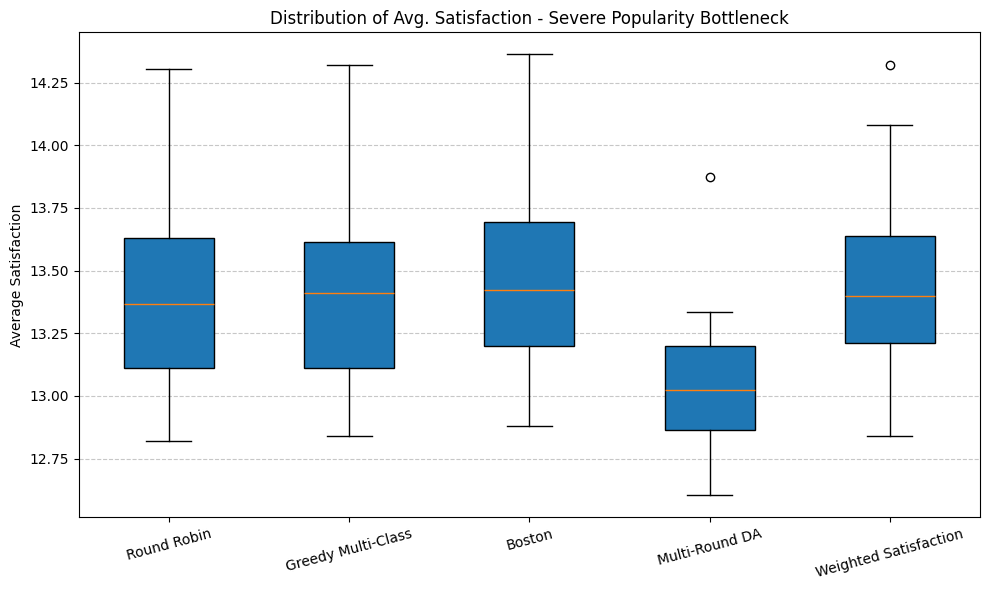


Max-Load + Undercapacity: Heavy student course loads combined with low class capacities; requires smart seat allocation to avoid collapse.
----------------------------------------------------------------------
Algorithm            Avg Sat.   Assign%    Full Sat%  Top Choice%  Runtime(ms) 
--------------------------------------------------------------------------------
Round Robin          32.09      98.50%     91.41%     100.00%      1.46        
Greedy Multi-Class   32.01      97.98%     88.91%     100.00%      1.76        
Boston               32.11      98.51%     91.25%     100.00%      1.47        
Multi-Round DA       31.41      97.03%     85.94%     100.00%      1.69        
Weighted Satisfaction 32.10      98.45%     91.09%     100.00%      1.40        


<ipython-input-6-4072e2d1d706>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


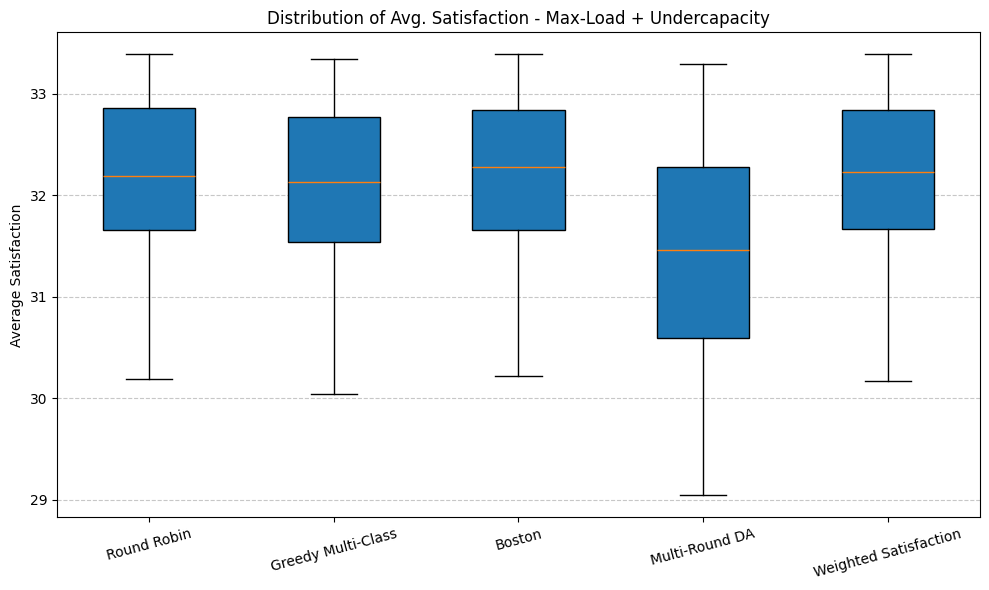


Extreme Preference Skew: Nearly all students want the same few classes; preference distribution is extreme. Exposes fragility of greedy algorithms.
----------------------------------------------------------------------
Algorithm            Avg Sat.   Assign%    Full Sat%  Top Choice%  Runtime(ms) 
--------------------------------------------------------------------------------
Round Robin          14.03      95.62%     81.07%     100.00%      0.85        
Greedy Multi-Class   14.01      95.22%     80.54%     100.00%      0.80        
Boston               14.04      95.66%     81.07%     100.00%      0.75        
Multi-Round DA       13.77      94.30%     77.32%     100.00%      0.93        
Weighted Satisfaction 14.04      95.66%     81.07%     100.00%      0.76        


<ipython-input-6-4072e2d1d706>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


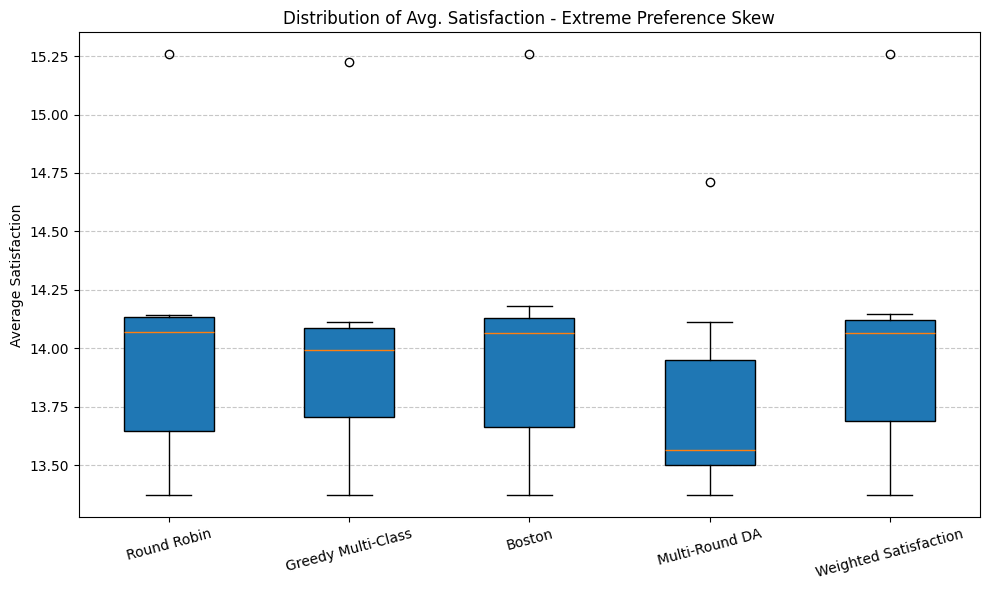


Low Preference Flexibility: Students list very few classes but expect full schedules. Pushes algorithms to deal with limited combinatorial flexibility.
----------------------------------------------------------------------
Algorithm            Avg Sat.   Assign%    Full Sat%  Top Choice%  Runtime(ms) 
--------------------------------------------------------------------------------
Round Robin          3.52       71.44%     25.68%     100.00%      0.64        
Greedy Multi-Class   3.52       71.44%     25.23%     100.00%      0.67        
Boston               3.52       71.44%     25.23%     100.00%      0.58        
Multi-Round DA       3.52       71.44%     25.68%     100.00%      0.86        
Weighted Satisfaction 3.52       71.44%     25.23%     100.00%      0.56        


<ipython-input-6-4072e2d1d706>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


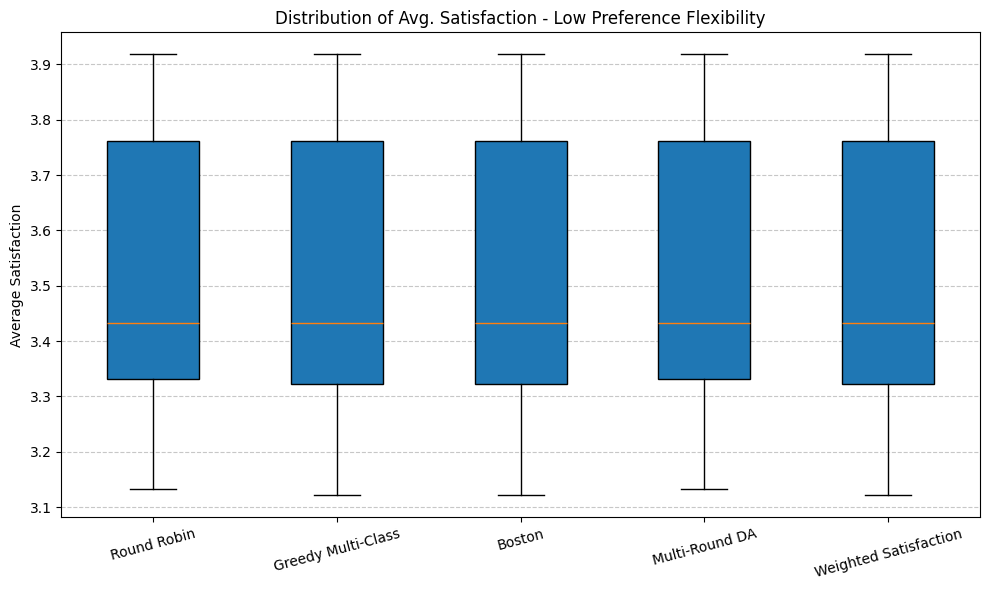


Nueva-Like w/ Capacity Squeeze: Realistic, competitive schedule with slight undercapacity and clustered demand. Closest stress test to a real school environment.
----------------------------------------------------------------------
Algorithm            Avg Sat.   Assign%    Full Sat%  Top Choice%  Runtime(ms) 
--------------------------------------------------------------------------------
Round Robin          27.36      100.00%    100.00%    100.00%      0.65        
Greedy Multi-Class   27.35      99.91%     99.58%     100.00%      0.80        
Boston               27.38      100.00%    100.00%    100.00%      0.66        
Multi-Round DA       26.25      96.86%     88.54%     100.00%      0.81        
Weighted Satisfaction 27.38      100.00%    100.00%    100.00%      0.68        


<ipython-input-6-4072e2d1d706>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


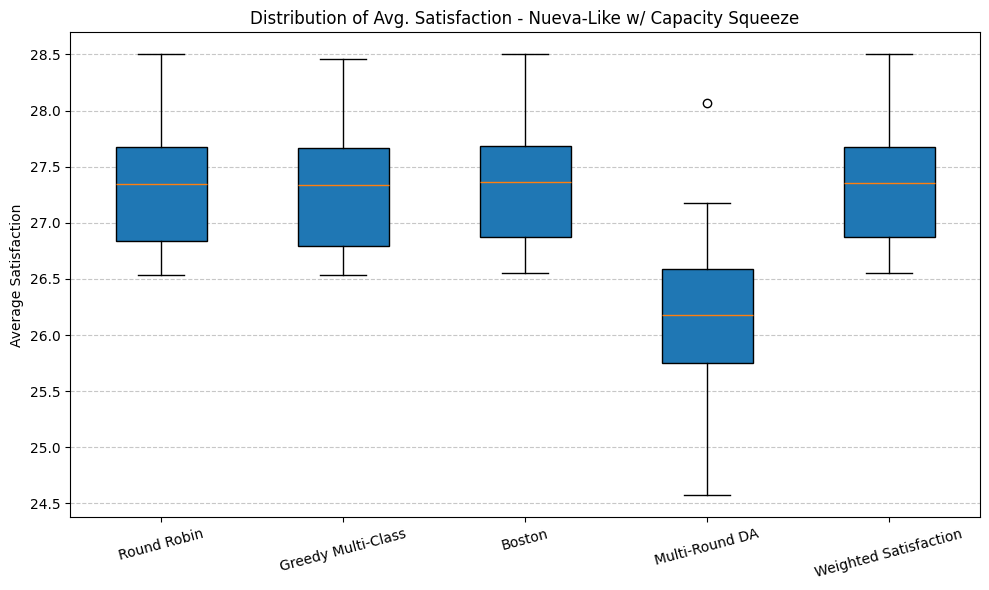


Scalability Stress Test: 1,000 students, moderate preference overlap, and realistic capacity. Tests algorithm speed, memory usage, and performance under scale.
----------------------------------------------------------------------
Algorithm            Avg Sat.   Assign%    Full Sat%  Top Choice%  Runtime(ms) 
--------------------------------------------------------------------------------
Round Robin          13.18      93.17%     79.42%     100.00%      10.81       
Greedy Multi-Class   13.18      93.03%     79.19%     100.00%      20.98       
Boston               13.19      93.19%     79.49%     100.00%      8.16        
Multi-Round DA       13.13      92.92%     78.66%     100.00%      10.65       
Weighted Satisfaction 13.19      93.18%     79.44%     100.00%      8.59        


<ipython-input-6-4072e2d1d706>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


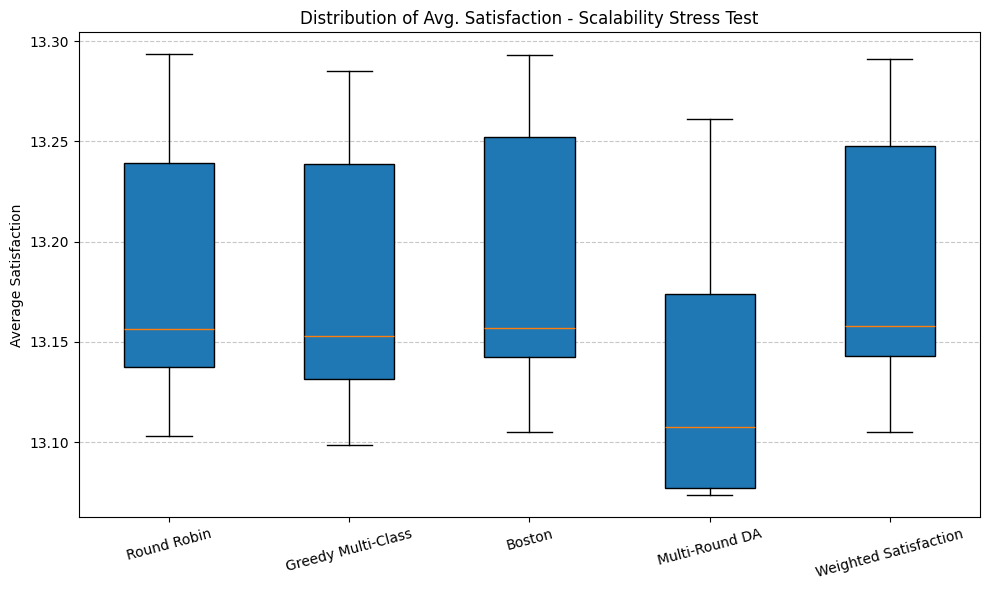

In [7]:
random.seed(0)
np.random.seed(0)

run_multiclass_analysis()